In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# see https://cookbook.openai.com/examples/embedding_wikipedia_articles_for_search
import mwclient  # for downloading example Wikipedia articles
import openai  # for generating embeddings
import os  # for environment variables
import pandas as pd  # for DataFrames to store article sections and embeddings
import re  # for cutting <ref> links out of Wikipedia articles
import tiktoken  # for counting tokens

In [4]:
from dotenv import load_dotenv  # for loading environment variables from a .env file
load_dotenv()  # load environment variables from .env file

client = openai.OpenAI(api_key=os.environ.get("OPENAI_API_KEY"))


In [5]:
import pandas as pd
import re, os

data_path = '/Users/toffe/dev/ai/novia/lib/serach-comparison/data/search_results.csv'
df = pd.read_csv(data_path)

In [6]:
df.head()

,title,citations,year,authors,journal,abstract,keywords,score,doi
0,Maritime Digital Twin architecture: A concept ...,26.0,2021.0,"Jan-Erik Giering, Alexander Dyck",Automatisierungstechnik,Digital Twins (DTs) play an important role in ...,Maritime Digital Twin Architecture; shipping; ...,-1,NaN
1,Real-time digital twin for ship operation in w...,19.0,2022.0,"Jae-Hoon Lee, Yoon-Seo Nam, Yonghwan Kim, Yumi...",Ocean Engineering,This paper introduces a real-time digital twin...,Digital twin; Ship operation in waves; Real-ti...,90,NaN
2,Real-time digital twin of research vessel for ...,16.0,2021.0,"Major, Pierre Yann; Li, Guoyuan; Zhang, Houxia...",Proceedings of 35th European Council for Model...,Real-time digital twins of ships in operation ...,Virtual Prototyping; Digital Twin; Remote Moni...,90,NaN
3,Digital Twin in the Maritime Domain: A Review ...,6.0,2023.0,"Nuwan Sri Madusanka,Yijie Fan,Shaolong Yang an...",J. Mar. Sci. Eng.,This paper highlights the development of Digit...,digital twin; digitalization; smart shipping; ...,80,NaN
4,From digital twin to maritime data space: Tran...,16.0,NaN,"Ørnulf Jan Rødseth, Arne J. Berre",Proc. 13th Int. Symp. Integr. Ship’s Inf. Syst...,The concept of the digital twin is gaining mom...,NaN,-1,NaN


In [7]:
import math
paper_strings = []
for index, row in df.iterrows():
    # Generate a string with the required fields
    year = int(row['year']) if 'year' in row and not math.isnan(row['year']) else 'N/A'
    #entry_string = f"""
    #    Title: {row['title']}\n
    #    Year: {year}\nAuthors: {row['authors']}\n
    #    Published in: {row['journal']}\n
    #    Abstract: {row['abstract']}\n
    #    Keywords: {row['keywords']}
    #"""
    entry_string = f"""{row['title']}\n{row['abstract']}\n"""
    paper_strings.append(entry_string)
    print(entry_string)

Maritime Digital Twin architecture: A concept for holistic Digital Twin application for shipbuilding and shipping
Digital Twins (DTs) play an important role in current digitalization trends across industries. As maritime markets are particularly affected by recent global tendencies such as increasing delivery costs or political pressure for decarbonization, DT solutions could provide important support for shipbuilding and shipping companies to master recent and upcoming challenges. This paper provides a brief insight into the current state of the maritime industry and shows possible use-cases for DT Ship applications throughout the entire product lifecycle. To further advance the general understanding of DTs and their implementation, the concept of a Maritime Digital Twin Architecture (MDTA) is proposed to structure practical DT features.

Real-time digital twin for ship operation in waves
This paper introduces a real-time digital twin for ship operations in seaways. The concept of the

In [8]:
len(paper_strings)

864

In [9]:
paper_strings[500]

'Gamification for Resilience: Resilient Informed Decision-Making\nnan\n'

In [10]:
EMBEDDING_MODEL = "text-embedding-3-large"
BATCH_SIZE = 1000  # you can submit up to 2048 embedding inputs per request

embeddings = []
for batch_start in range(0, len(paper_strings), BATCH_SIZE):
    batch_end = batch_start + BATCH_SIZE
    batch = paper_strings[batch_start:batch_end]
    print(f"Batch {batch_start} to {batch_end-1}")
    response = client.embeddings.create(model=EMBEDDING_MODEL, input=batch)
    for i, be in enumerate(response.data):
        assert i == be.index  # double check embeddings are in same order as input
    batch_embeddings = [e.embedding for e in response.data]
    embeddings.extend(batch_embeddings)

df = df.assign(text=paper_strings, embedding=embeddings)


Batch 0 to 999
<Request('POST', 'https://api.openai.com/v1/embeddings')>


In [11]:
df.head()

,title,citations,year,authors,journal,abstract,keywords,score,doi,text,embedding
0,Maritime Digital Twin architecture: A concept ...,26.0,2021.0,"Jan-Erik Giering, Alexander Dyck",Automatisierungstechnik,Digital Twins (DTs) play an important role in ...,Maritime Digital Twin Architecture; shipping; ...,-1,NaN,Maritime Digital Twin architecture: A concept ...,"[-0.01799747347831726, 0.022573575377464294, -..."
1,Real-time digital twin for ship operation in w...,19.0,2022.0,"Jae-Hoon Lee, Yoon-Seo Nam, Yonghwan Kim, Yumi...",Ocean Engineering,This paper introduces a real-time digital twin...,Digital twin; Ship operation in waves; Real-ti...,90,NaN,Real-time digital twin for ship operation in w...,"[-0.015836460515856743, -0.008358885534107685,..."
2,Real-time digital twin of research vessel for ...,16.0,2021.0,"Major, Pierre Yann; Li, Guoyuan; Zhang, Houxia...",Proceedings of 35th European Council for Model...,Real-time digital twins of ships in operation ...,Virtual Prototyping; Digital Twin; Remote Moni...,90,NaN,Real-time digital twin of research vessel for ...,"[-0.018611136823892593, 0.01980859786272049, -..."
3,Digital Twin in the Maritime Domain: A Review ...,6.0,2023.0,"Nuwan Sri Madusanka,Yijie Fan,Shaolong Yang an...",J. Mar. Sci. Eng.,This paper highlights the development of Digit...,digital twin; digitalization; smart shipping; ...,80,NaN,Digital Twin in the Maritime Domain: A Review ...,"[-0.011682220734655857, 0.04051842913031578, -..."
4,From digital twin to maritime data space: Tran...,16.0,NaN,"Ørnulf Jan Rødseth, Arne J. Berre",Proc. 13th Int. Symp. Integr. Ship’s Inf. Syst...,The concept of the digital twin is gaining mom...,NaN,-1,NaN,From digital twin to maritime data space: Tran...,"[-0.010125835426151752, 0.024245159700512886, ..."


In [12]:
df.to_csv('data/papers.csv', index=False)


In [13]:
from typing import List, Optional
from scipy import spatial

client: openai.OpenAI
distance_metric="cosine"

def get_sorted_list_of_papers(q: str="foo", limit=1000, df=df) -> pd.DataFrame:
    # Calculate the query embedding
    batch = [str(q)]
    try:
        response = client.embeddings.create(model=EMBEDDING_MODEL, input=batch)
        for i, be in enumerate(response.data):
            assert i == be.index  # double check embeddings are in same order as input
        e = [e.embedding for e in response.data]
        query_embedding = e[0]
    except Exception as e:
        raise e
        return
    print(e)
    # Define distance metrics
    distance_metrics = {
        "cosine": spatial.distance.cosine,
        "L1": spatial.distance.cityblock,
        "L2": spatial.distance.euclidean,
        "Linf": spatial.distance.chebyshev,
    }
    
    # Calculate distances
    distances = [
        distance_metrics[distance_metric](query_embedding, embedding)
        for embedding in df['embedding'].tolist()
    ]
    
    # Add distances to the DataFrame
    df2 = df.assign(distance=distances)
    
    # Sort the DataFrame by distance
    sorted_df = df2.sort_values(by='distance')
    
    return sorted_df

In [14]:
q = "digital twin for virutal ship commissioning"
papers = get_sorted_list_of_papers(q,  500, df)
papers.head()


<Request('POST', 'https://api.openai.com/v1/embeddings')>
[[-0.0166514590382576, 0.020240996032953262, -0.013535542413592339, -0.04669720679521561, 0.03965108096599579, -0.0036476999521255493, -0.030095601454377174, 0.05769846960902214, -0.024511879310011864, 0.026722101494669914, 0.030062364414334297, -0.0509847067296505, -0.026572538539767265, -0.010427935048937798, -0.003759872866794467, 0.021470744162797928, -0.009779823943972588, 0.016418803483247757, -0.015006255358457565, -0.020855870097875595, 0.030594147741794586, 0.02663901075720787, -0.001300375908613205, 0.019326992332935333, -0.023464931175112724, -0.025658536702394485, -0.005895314738154411, 0.01046948041766882, 0.014840072952210903, -0.021803108975291252, 0.03612801805138588, 0.01729957014322281, -0.009671805426478386, -0.02054012380540371, 0.017764879390597343, -0.01856255531311035, -0.0013107623672112823, -0.010178661905229092, 0.006514343433082104, -0.00235355575568974, -0.011283772997558117, -0.02742006815969944, -0.

,title,citations,year,authors,journal,abstract,keywords,score,doi,text,embedding,distance
35,Using Digital Twin in a Shipbuilding Project,11.0,2022.0,"Zoran KunkeraTihomir Opetuk,Neven Hadžić, Nata...",Applied sciences,Three-dimensional modelling software tools ena...,Digital Twin; Virtual Reality; Shipyard 4.0; C...,80,NaN,Using Digital Twin in a Shipbuilding Project\n...,"[-0.018111374229192734, 0.005091701168566942, ...",0.345060
315,A ship digital twin framework based on virtual...,6.0,NaN,Jing Q.,Beijing Jiaotong Daxue Xuebao/Journal of Beiji...,NaN,NaN,60,10.11860/j.issn.1673-0291.20200076,A ship digital twin framework based on virtual...,"[-0.041790395975112915, 0.017385710030794144, ...",0.346600
93,Digital Twin for Firefighting System on Ships,0.0,2023.0,Sara Ferreno-Gonzalez; Vicente Diaz-Casas; Mar...,The 33rd International Ocean and Polar Enginee...,A digital twin is a replica of a physical asse...,"law enforcement, public safety, marine transpo...",-1,NaN,Digital Twin for Firefighting System on Ships\...,"[-0.030992144718766212, 0.02514665201306343, -...",0.356932
50,Digital Twins for Warship Systems: Technologie...,1.0,2022.0,"Sara Ferreno-Gonzalez, Alicia Munin-Doce, Marc...",IoT for Defense and National Security,Thanks to the development of new technologies ...,Thanks to the development of new technologies ...,90,NaN,Digital Twins for Warship Systems: Technologie...,"[-0.02492578513920307, 0.039251264184713364, -...",0.359714
8,Digital twins for the maritime sector,11.0,2020.0,"Mikael Lind, Hanane Becha, Richard T. Watson, ...",Smart Maritime Network,A digital twin is a dynamic digital representa...,NaN,-1,NaN,Digital twins for the maritime sector\nA digit...,"[-0.014704324305057526, 0.017083976417779922, ...",0.366795


In [15]:
from umap import UMAP
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

# Function to update the UMAP plot
def update_umap(n_neighbors, min_dist):
    umap = UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=2,
        random_state=42,
    )
    
    umap_embeddings = umap.fit_transform(X_tfm)
    
    plt.figure(figsize=(8, 6))
    plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1],
                s=0.1, cmap='Spectral')
    plt.title(f"UMAP with n_neighbors={n_neighbors}, min_dist={min_dist}")
    plt.show()

# Convert the 'embedding' column from string to list of floats
X_tfm = papers['embedding'].tolist()

# Create sliders for n_neighbors and min_dist
n_neighbors_slider = widgets.IntSlider(value=5, min=2, max=50, step=1, description='n_neighbors')
min_dist_slider = widgets.FloatSlider(value=0.0, min=0.0, max=1.0, step=0.01, description='min_dist')

# Display the sliders and the plot
widgets.interactive(update_umap, n_neighbors=n_neighbors_slider, min_dist=min_dist_slider)

/Users/toffe/miniforge3/envs/dl_env_p12/lib/python3.12/site-packages/ipywidgets/widgets/interaction.py:43: DeprecationWarning: `ipykernel.pylab.backend_inline` is deprecated, directly use `matplotlib_inline.backend_inline`
  from ipykernel.pylab.backend_inline import flush_figures


interactive(children=(IntSlider(value=5, description='n_neighbors', max=50, min=2), FloatSlider(value=0.0, des…

In [22]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

def get_clusters(data, max_clusters=10):
    silhouette_scores = []
    K_to_try = range(2, max_clusters + 1)  # Start from 2 clusters to avoid division by zero in silhouette score
    
    for k in K_to_try:
        kmeans = KMeans(n_clusters=k, random_state=0).fit(data)
        # Calculate silhouette score for each k
        if k > 1:
            score = silhouette_score(data, kmeans.labels_)
            silhouette_scores.append(score)
    
    # Silhouette score: highest score
    silhouette_k = np.argmax(silhouette_scores) + 2  # +2 because index 0 corresponds to k=2


    # Apply K-means clustering to the UMAP embeddings
    kmeans = KMeans(n_clusters=silhouette_k, random_state=0).fit(data)
    labels = kmeans.labels_

    return silhouette_k, labels

umap = UMAP(
    n_neighbors=max(2, min(len(X_tfm[0]) - 1, int(len(X_tfm) * 0.1), 50)),
    min_dist=0.0,
    random_state=None,
    n_jobs=-1
)

umap_embeddings = umap.fit_transform(X_tfm)

k, kluster_labels = get_clusters(umap_embeddings, 10)


In [24]:
print(k, kluster_labels)

2 [1 0 1 1 1 1 1 1 0 0 0 1 1 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1
 1 1 1 1 1 0 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1
 0 1 0 1 0 0 1 1 1 1 1 1 1 0 1 0 1 1 1 1 0 0 1 1 1 1 1 0 1 1 1 1 1 0 1 0 1
 0 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 0 0 0 1 0 1 0 1 0 1
 1 1 1 1 1 1 0 0 1 0 1 1 1 1 1 1 0 1 1 1 0 1 1 0 1 0 1 1 1 1 1 1 0 0 1 1 1
 1 1 0 1 1 0 1 1 0 1 1 0 1 1 0 1 1 1 0 1 0 1 1 1 0 1 0 1 1 0 1 1 1 0 1 1 1
 1 0 0 1 1 1 0 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 0 1 0 1 1 0 1
 1 1 1 0 1 1 1 0 1 1 1 0 1 1 1 1 1 0 1 0 1 1 0 1 1 1 0 1 1 1 0 1 1 0 1 0 0
 1 1 1 1 1 1 0 1 1 0 1 1 0 0 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 0 1 0 0 1 1 1 1
 1 1 1 1 1 0 1 0 1 1 0 1 1 0 1 1 1 0 1 1 1 1 1 1 0 0 1 1 1 0 0 1 1 1 0 1 1
 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 1 1 0 0 1 0 1 1 1 0 0 1 0 1 1 1 1 1 1 1 1 1
 0 1 1 0 0 0 1 0 1 0 1 1 1 0 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 0 0 1 0 1 1 1 1 1 0 0 1 1 1 0 0 1
 1 1 0 1 1 1 1 1 0 1 1 

In [26]:
from sklearn.preprocessing import normalize
embeddings_normalized = normalize(X_tfm)
embeddings_normalized

array([[-0.01811137,  0.0050917 , -0.02593745, ..., -0.00699047,
        -0.0002624 , -0.01225541],
       [-0.0417904 ,  0.01738571, -0.01884126, ..., -0.00585454,
        -0.0014414 ,  0.00523189],
       [-0.03099214,  0.02514665, -0.02507772, ...,  0.00056956,
        -0.01542714,  0.00233337],
       ...,
       [-0.05332279, -0.00269812, -0.00898343, ..., -0.006005  ,
         0.01712768, -0.00997395],
       [-0.03624998,  0.00897593, -0.02499677, ...,  0.00262353,
        -0.00132924,  0.00218073],
       [-0.01661793,  0.00625789, -0.02264559, ..., -0.01043679,
         0.03708687,  0.00611836]])

In [27]:
from sklearn.decomposition import PCA
pca = PCA(n_components=50)  # Adjust n_components as needed
embeddings_reduced = pca.fit_transform(embeddings_normalized)

In [28]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=k)
labels = kmeans.fit_predict(embeddings_reduced)

Optimal number of clusters: 4
Silhouette Score for k=4: 0.09947474854645086


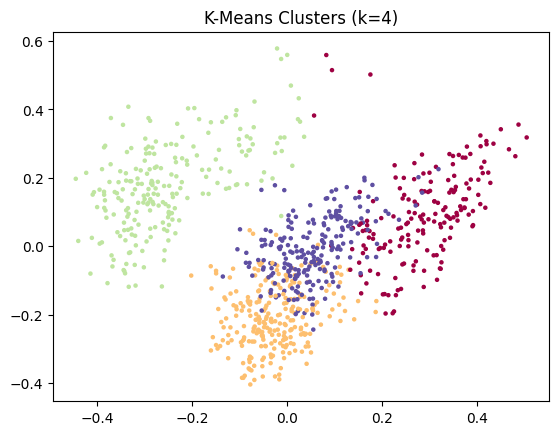

In [30]:
# Step 1: Load Embeddings
import numpy as np
embeddings = X_tfm#np.load('embeddings.npy')  # Replace with your data loading method

# Step 2: Preprocess (Optional)
from sklearn.preprocessing import normalize
embeddings_normalized = normalize(embeddings)

# Step 3: Dimensionality Reduction (Optional)
from sklearn.decomposition import PCA
pca = PCA(n_components=50)
embeddings_reduced = pca.fit_transform(embeddings_normalized)

# Step 4: Determine Optimal k (For K-Means)
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
K = range(2, 10)
best_k = 0
best_score = -1
for k in K:
    kmeans = KMeans(n_clusters=k)
    labels = kmeans.fit_predict(embeddings_reduced)
    score = silhouette_score(embeddings_reduced, labels)
    if score > best_score:
        best_k = k
        best_score = score

print(f'Optimal number of clusters: {best_k}')

# Step 5: Cluster with Optimal k
kmeans = KMeans(n_clusters=best_k)
labels = kmeans.fit_predict(embeddings_reduced)

# Step 6: Evaluate Clustering
score = silhouette_score(embeddings_reduced, labels)
print(f'Silhouette Score for k={best_k}: {score}')

# Step 7: Visualize Clusters (If 2D)
plt.scatter(embeddings_reduced[:, 0], embeddings_reduced[:, 1], c=labels, cmap='Spectral', s=5)
plt.title(f'K-Means Clusters (k={best_k})')
plt.show()

In [36]:
#k-menans based
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=k)
labels = kmeans.fit_predict(embeddings_reduced)
len(set(labels))

9

In [37]:
# Hierarchical
from scipy.cluster.hierarchy import linkage, fcluster
Z = linkage(embeddings_reduced, method='ward')
labels = fcluster(Z, t=k, criterion='maxclust')
len(set(labels))

9

In [18]:
# Add UMAP embeddings to the DataFrame
papers['umap_x'] = umap_embeddings[:, 0]
papers['umap_y'] = umap_embeddings[:, 1]

# Save the DataFrame to a JSON file
papers.to_csv('data/papers_with_umap.csv', index=False)


In [38]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
labels = dbscan.fit_predict(embeddings_reduced)
len(set(labels))

9

In [44]:
#  DBSCAN -- does not need k up fornt
#!pip install hdbscan

import hdbscan

clusterer = hdbscan.HDBSCAN()
labels = clusterer.fit_predict(embeddings_reduced)
len(set(labels))

4

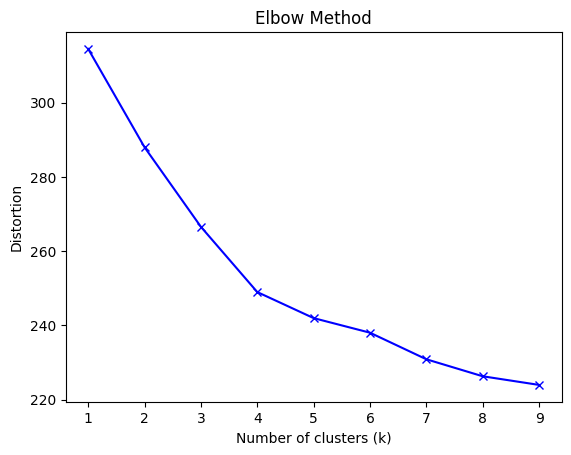

In [45]:
distortions = []
K = range(1, 10)
for k in K:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(embeddings_reduced)
    distortions.append(kmeans.inertia_)

import matplotlib.pyplot as plt
plt.plot(K, distortions, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Distortion')
plt.title('Elbow Method')
plt.show()

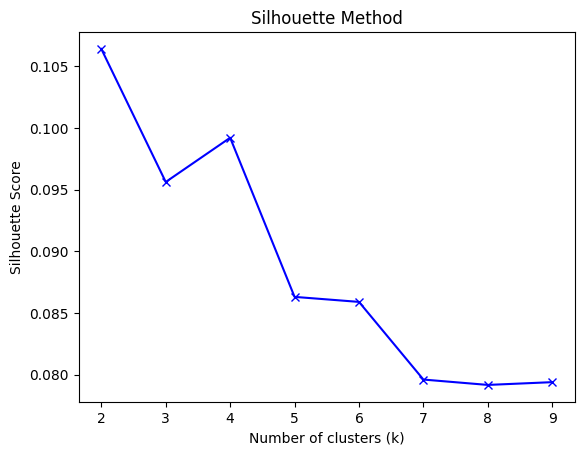

In [46]:
from sklearn.metrics import silhouette_score
silhouette_scores = []
K = range(2, 10)
for k in K:
    kmeans = KMeans(n_clusters=k)
    labels = kmeans.fit_predict(embeddings_reduced)
    score = silhouette_score(embeddings_reduced, labels)
    silhouette_scores.append(score)

plt.plot(K, silhouette_scores, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method')
plt.show()

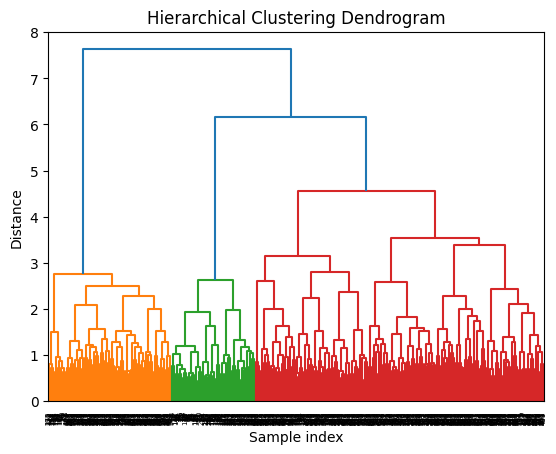

In [47]:
from scipy.cluster.hierarchy import dendrogram
dendrogram(Z)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.show()

In [48]:
score = silhouette_score(embeddings_reduced, labels)
print(f'Silhouette Score: {score}')

Silhouette Score: 0.07939658529144611


In [49]:
from sklearn.metrics import calinski_harabasz_score
score = calinski_harabasz_score(embeddings_reduced, labels)
print(f'Calinski-Harabasz Index: {score}')

Calinski-Harabasz Index: 43.77541067818244


In [50]:
from sklearn.metrics import davies_bouldin_score
score = davies_bouldin_score(embeddings_reduced, labels)
print(f'Davies-Bouldin Index: {score}')

Davies-Bouldin Index: 2.886311123460612


In [51]:
num_clusters = len(set(labels)) - (1 if -1 in labels else 0)
print(f'Estimated number of clusters: {num_clusters}')

Estimated number of clusters: 9


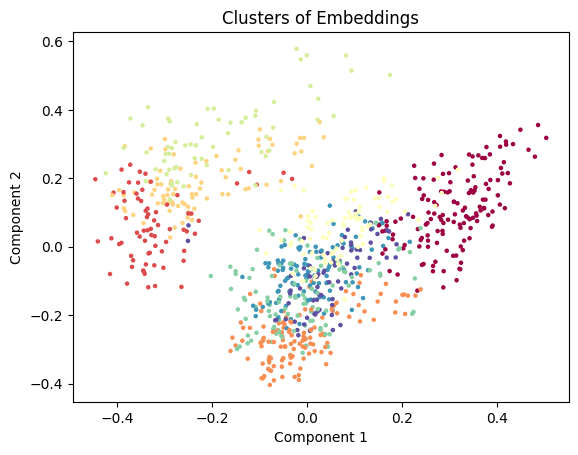

In [52]:
plt.scatter(embeddings_reduced[:, 0], embeddings_reduced[:, 1], c=labels, cmap='Spectral', s=5)
plt.title('Clusters of Embeddings')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

Optimal number of clusters: 2
Silhouette Score for k=2: 0.10626321786545992


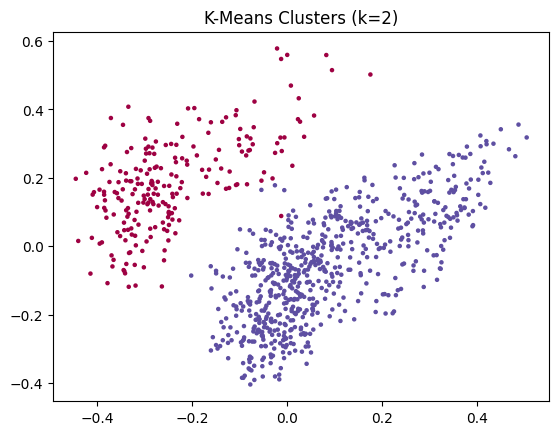

In [55]:
# Step 1: Load Embeddings
import numpy as np
embeddings =  X_tfm # Replace with your data loading method

# Step 2: Preprocess (Optional)
from sklearn.preprocessing import normalize
embeddings_normalized = normalize(embeddings)

# Step 3: Dimensionality Reduction (Optional)
from sklearn.decomposition import PCA
pca = PCA(n_components=50)
embeddings_reduced = pca.fit_transform(embeddings_normalized)

# Step 4: Determine Optimal k (For K-Means)
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
K = 9
best_k = 9
print(f'Optimal number of clusters: {best_k}')

# Step 5: Cluster with Optimal k
kmeans = KMeans(n_clusters=best_k)
labels = kmeans.fit_predict(embeddings_reduced)

# Step 6: Evaluate Clustering
score = silhouette_score(embeddings_reduced, labels)
print(f'Silhouette Score for k={best_k}: {score}')

# Step 7: Visualize Clusters (If 2D)
plt.scatter(embeddings_reduced[:, 0], embeddings_reduced[:, 1], c=labels, cmap='Spectral', s=5)
plt.title(f'K-Means Clusters (k={best_k})')
plt.show()
